# Sanity Check on Pupil Labs Data

In [74]:
import ProtobufTypes_pb2 
import pandas as pd
import sys
import json
import inspect
from google.protobuf.json_format import MessageToDict
from google.protobuf.json_format import MessageToJson
from pandas.io.json import json_normalize
import collections
import numpy as np
from IPython.display import display, HTML

### Read Pupil Data from protobuf

In [44]:
protobuf_obj = ProtobufTypes_pb2.EyetrackingDataSet()
# print(et_data.SerializeToString())
with open('Pupil.etd', "rb") as f:
    protobuf_obj.ParseFromString(f.read())
dict_obj = MessageToDict(protobuf_obj)

In [45]:
#Flatten the dictionary for easy df conversion
def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        nk = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, nk, sep=sep).items())
        else:
            items.append((nk,v))
    return dict(items)

In [46]:
val_df = pd.concat([pd.DataFrame(flatten(samples), index=[idx]) 
            for idx, samples in enumerate(dict_obj['validationSamples'])],
            ignore_index=True)


/home/lonesome/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
val_df.isna().mean()

combinedEyeAngleOffset_x    0.000000
combinedEyeAngleOffset_y    0.000000
combinedEyeAngleOffset_z    0.000000
headTransform_position_x    0.000000
headTransform_position_y    0.000000
headTransform_position_z    0.000000
headTransform_rotation_w    0.000000
headTransform_rotation_x    0.000000
headTransform_rotation_y    0.000000
headTransform_rotation_z    0.000000
headTransform_scale_x       0.000000
headTransform_scale_y       0.000000
headTransform_scale_z       0.000000
leftEyeAngleOffset_x        0.289858
leftEyeAngleOffset_y        0.289858
leftEyeAngleOffset_z        0.289858
pointToFocus_x              0.000000
pointToFocus_y              0.000000
pointToFocus_z              0.000000
rightEyeAngleOffset_x       0.893509
rightEyeAngleOffset_y       0.893509
rightEyeAngleOffset_z       0.893509
dtype: float64

Pupil labs returns upto 89% of data as mean only during the validation period.

In [6]:
val_df.columns

Index(['combinedEyeAngleOffset_x', 'combinedEyeAngleOffset_y',
       'combinedEyeAngleOffset_z', 'headTransform_position_x',
       'headTransform_position_y', 'headTransform_position_z',
       'headTransform_rotation_w', 'headTransform_rotation_x',
       'headTransform_rotation_y', 'headTransform_rotation_z',
       'headTransform_scale_x', 'headTransform_scale_y',
       'headTransform_scale_z', 'leftEyeAngleOffset_x', 'leftEyeAngleOffset_y',
       'leftEyeAngleOffset_z', 'pointToFocus_x', 'pointToFocus_y',
       'pointToFocus_z', 'rightEyeAngleOffset_x', 'rightEyeAngleOffset_y',
       'rightEyeAngleOffset_z'],
      dtype='object')

In [48]:
#change angles to be within 180 degrees
sel_columns = ['combinedEyeAngleOffset_x', 'combinedEyeAngleOffset_y','combinedEyeAngleOffset_z',
               'leftEyeAngleOffset_x', 'leftEyeAngleOffset_y','leftEyeAngleOffset_z',
               'rightEyeAngleOffset_x', 'rightEyeAngleOffset_y','rightEyeAngleOffset_z']

for col in sel_columns:
    val_df.loc[val_df[col]>180, col] = 360 - val_df[col] 

### Plot the Validation error distribution for Left, Right and Cyclopean eye

(-5, 30)

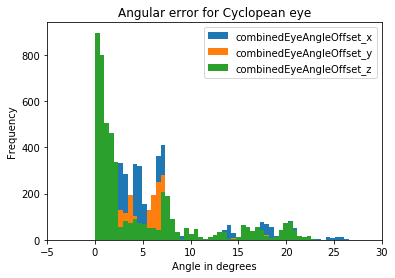

In [90]:
ax = val_df.loc[:,['combinedEyeAngleOffset_x','combinedEyeAngleOffset_y','combinedEyeAngleOffset_z']]\
    .plot.hist(title='Angular error for Cyclopean eye', bins =200)
ax.set_xlabel('Angle in degrees')
ax.set_xlim((-5, 30))

(-5, 30)

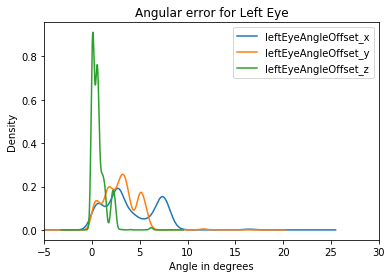

In [60]:
ax = val_df.loc[:,['leftEyeAngleOffset_x', 'leftEyeAngleOffset_y','leftEyeAngleOffset_z']]\
    .plot.kde(title='Angular error for Left Eye')
ax.set_xlabel('Angle in degrees')
ax.set_xlim((-5, 30))

Text(0.5, 0, 'Angle in degrees')

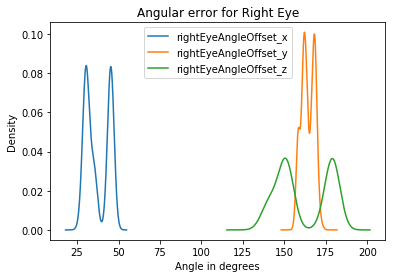

In [63]:
ax = val_df.loc[:,['rightEyeAngleOffset_x', 'rightEyeAngleOffset_y','rightEyeAngleOffset_z']]\
    .plot.kde(title='Angular error for Right Eye')
ax.set_xlabel('Angle in degrees')
# ax.set_xlim((-5, 100))

In [40]:
print(dict_obj.keys())

dict_keys(['subjectID', 'trials', 'validationSamples'])


In [41]:
# Create DF for initial config, before start of each trial

ini_conf = pd.DataFrame()
for trial in dict_obj['trials']:
    temp = pd.concat([pd.DataFrame(flatten(conf), index=[idx]) 
            for idx, conf in enumerate(trial['metaData']['initialConfiguration']['items'])],
              ignore_index=True, sort=True )
    temp['trialID'] = trial['metaData']['trialID']
    ini_conf = pd.concat([ini_conf,temp],ignore_index=True, sort=True)
ini_conf['subjectID'] = dict_obj['subjectID']

In [42]:
# create DF for the eye samples
samples = pd.DataFrame()
for trial in dict_obj['trials']:
    temp = pd.concat([ pd.DataFrame(flatten(samp), index=[idx])
                      for idx, samp in enumerate(trial['samples'])], ignore_index=True, sort=False)
    temp['trialID'] = trial['metaData']['trialID']
    samples = pd.concat([samples,temp],ignore_index=True, sort=True)
samples['subjectID'] = dict_obj['subjectID']

In [79]:
# pd.set_option('display.height', 1000)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(samples.isna().mean())


combinedEye_direction_x             0.000000
combinedEye_direction_y             0.233152
combinedEye_direction_z             0.000000
combinedEye_position_x              0.000000
combinedEye_position_y              0.000000
combinedEye_position_z              0.000000
combinedEye_raycastHitLocation_x    0.000000
combinedEye_raycastHitLocation_y    0.116935
combinedEye_raycastHitLocation_z    0.000000
combinedEye_raycastHitObject        0.000000
handData_gridPosition_x             0.000000
handData_gridPosition_y             0.000000
handData_transform_position_x       0.000000
handData_transform_position_y       0.000000
handData_transform_position_z       0.000000
handData_transform_rotation_w       0.000000
handData_transform_rotation_x       0.000000
handData_transform_rotation_y       0.000000
handData_transform_rotation_z       0.000205
handData_transform_scale_x          0.000000
handData_transform_scale_y          0.000000
handData_transform_scale_z          0.000000
headTransf

In [85]:
samples['unixTimestamp_seconds'].shape

(9749,)

In [86]:
samples['unixTimestamp_seconds'].unique().shape

(128,)

In [87]:
samples['timestamp'].shape

(9749,)

In [88]:
samples['timestamp'].unique().shape

(1,)

In [84]:
samples['trialID'].unique()

array([ 5, 11,  3,  4])